# WATER BAG TIME SERIE CLASSIFICATION - Prediction Range Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [4]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import (
    groupConsecutiveFlags, MinorityGroupSplitUndersample,
    group_metrics, scoring, cross_val_predict_proba
)
from Modulos.probability import (
    predict_proba, scale_proba, clf_score, precision_recall_plot,
    groups_windows, window_prob, multi_window_prob
)

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, LabelEncoder
from sklearn.model_selection import cross_validate, TimeSeriesSplit
# from sklearn.feature_selection import SelectFromModel, SelectKBest
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

## Utility Funcitons

In [15]:
def custom_preprocessing(X, drop_empty_cols=False, label_encode=None, interpolate='linear', fillna='mean'):

    print('Initial shape:', X.shape)

    if drop_empty_cols: # Drop X empty columns and rows
        X.dropna(axis=1, how='all', inplace=True)
        print('Empty columns removed: ', X.shape)

    if label_encode is not None:
        print('Label columns encoded:', list(label_encode))
        LEi = {}
        for col in label_encode:
            LEi[col] = le().fit(X[col])
            X[col] = LEi[col].transform(X[col])

    if interpolate is not None: # Interpolate X missing values
        print('Interpolation:', interpolate)
        X = X.interpolate(interpolate)

    if fillna is not None: # Fill missing values with the minimum column value
        print('Fill missing values:', fillna)
        for col in X:
            if fillna=='min':
                fill_value = X[col].min()
            elif fillna=='mean':
                fill_value = X[col].mean()
            else:
                fill_value = 0
            X[col].fillna(fill_value, inplace=True)

    if label_encode is not None:
        return X, LEi
    return X

# Target selection and train/test split
def select_target(target_id, periods_ahead, shift=0):
    print(f'Selected Target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    y_cnt = Y.value_counts().to_frame('Target')

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(1 - periods_ahead) > 0).astype('float')
        print('Target range:', periods_ahead)
    if shift is not None:
        Y = Y.shift(shift, fill_value=0.0)
        print('Target shift:', periods_ahead)

    y_cnt = pd.concat([y_cnt, Y.value_counts().to_frame('Transformed Target')], axis=1)

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)
    
    return Y, groups, y_cnt

def target_params_evaluation(target_id, params, pipe, sel_thresh=0.5):

    scrs = []
    for i, param in enumerate(params):
        co(wait=True); print(f'{i+1}/{len(params)} shift values evaluated.')

        ### Target variable
        
        Y, groups, y_cnt = select_target(target_id, **param)

        # Target validation split
        yt = Y.loc[xt.index]
        ye = Y.loc[xe.index]
        groups_train = groups.loc[xt.index]
        groups_eval = groups.loc[xe.index]

        ### Fit and predict with model pipeline

        # Fit pipeline
        pipe.fit(xt, yt)

        # Predict Probability
        yprob = predict_proba(pipe, xe)
        # yprob = scale_proba(yprob, 0.5, limit=None)

        ### Prediction evaluation

        grp_curve = group_metrics.group_precision_recall_curve(ye, yprob, groups_eval, num=50)
        scr_grp = grp_curve[sel_thresh:].iloc[0]
        scr = clf_score(ye, yprob, sel_thresh).rename(columns={'f1-score': 'f1'})

        scr = pd.concat([scr.loc['1.0'].add_suffix('-1'), scr_grp], axis=0)
        for key in param.keys():
            scr[key] = param[key]
        scrs.append(scr)

    scrs = pd.concat(scrs, axis=1).T
    return scrs

---
## Load & Preprocess Data

In [7]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Drop specific columns from trining dataset
out_time = ['index', 'year', 'date']
out_stations = ['A652', 'A654']
out_inmet = [col for col in data if np.any([station in col for station in out_stations])]

out_cols = out_time + out_inmet
data.drop(out_cols, axis=1, inplace=True)

print('Dataset shape:', data.shape)

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


Dataset shape: (437875, 213)


---
# 1. Preprocessing & Data Transformation

## Preprocessing

In [8]:
label_cols = data.columns[:9]

transform_args = dict(
    label_encode=label_cols,
    interpolate='nearest', fillna='mean'
)

data_encoded, encoder = custom_preprocessing(data.copy(), **transform_args)

Initial shape: (437875, 213)
Label columns encoded: ['month', 'day', 'hour', 'minute', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: nearest
Fill missing values: mean


### Target rolling proportion

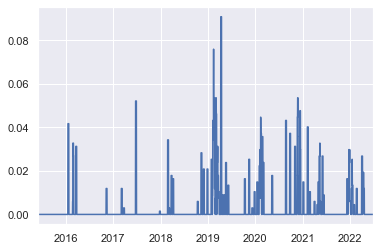

In [9]:
target_id = '1'
periods_ahead = 4

window = 7*24*4 
ax = Yi.loc['2015-06': , target_id].rolling(window).mean().plot()

### Feature set

In [10]:
n_splits = 5
train_start, train_end = '2019-07', '2020-12'
eval_start, eval_end = '2021-01', '2022-04'

X = data_encoded[train_start: eval_end].copy()

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

non_constant = X.columns[[len(X[col].unique()) != 1 for col in X.columns]]

---
# 3. Simple split pipeline evaluation

### Base model

### Selected model pipeline

In [12]:
import sklearn.neural_network as nn

mlp = nn.MLPClassifier

model = mlp(
    (100,), verbose=1, random_state=0, batch_size=200,
    early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=5, tol=0.005, max_iter=50,
)

seed = 0

train_prct = 0.025
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)

# Pipeline
pipe = Pipeline([('scale', mms()), ('under', rus), ('model', model)])

---
# Target shift evaluation

In [13]:
scr_cols = np.array(['precision-1', 'recall-1', 'f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

### Period shift evaluation

In [16]:
target_id = '1'
sel_thresh = 0.5
shifts = range(-15, 15, 1)

params = [{'shift': shift, 'periods_ahead': 4} for shift in shifts]
scrs_shift = target_params_evaluation(target_id, params, pipe, sel_thresh=0.5).set_index('shift')

30/30 shift values evaluated.
Selected Target: Rua do Catete - id: 1 

Target range: 4
Target shift: 4
Iteration 1, loss = 0.11495655
Validation score: 0.979798
Iteration 2, loss = 0.05441705
Validation score: 0.983165
Iteration 3, loss = 0.04817197
Validation score: 0.985185
Iteration 4, loss = 0.04441884
Validation score: 0.983838
Iteration 5, loss = 0.04138210
Validation score: 0.985859
Iteration 6, loss = 0.03865736
Validation score: 0.986532
Iteration 7, loss = 0.03598510
Validation score: 0.987205
Validation score did not improve more than tol=0.005000 for 5 consecutive epochs. Stopping.
predict_proba method used.


### Shift value scores

In [65]:
scrs_shift['shift (td)'] = pd.date_range(0, periods=len(scrs_shift), freq='15Min').shift(scrs_shift.index[0])

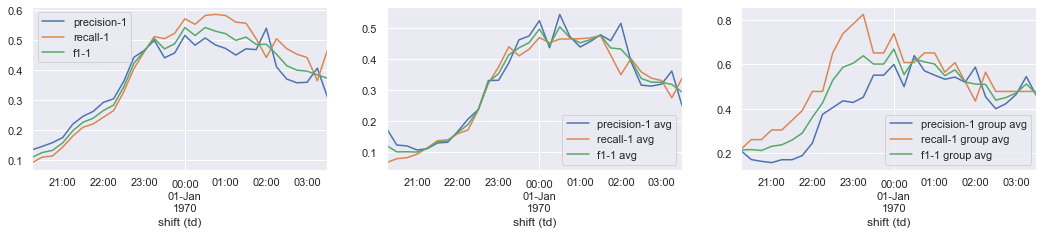

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_shift.set_index('shift (td)')[scr_cols + col_type].plot(ax=ax[i])
plt.show()

### Period range evaluation

19/19 shift values evaluated.
Selected Target: Rua do Catete - id: 1 

Target range: 18
Target shift: 18
Iteration 1, loss = 0.09524215
Validation score: 0.984474
Iteration 2, loss = 0.05817370
Validation score: 0.986944
Iteration 3, loss = 0.05236531
Validation score: 0.986239
Iteration 4, loss = 0.04900549
Validation score: 0.986591
Iteration 5, loss = 0.04584702
Validation score: 0.987297
Iteration 6, loss = 0.04342812
Validation score: 0.988003
Iteration 7, loss = 0.04196415
Validation score: 0.987650
Validation score did not improve more than tol=0.005000 for 5 consecutive epochs. Stopping.
predict_proba method used.


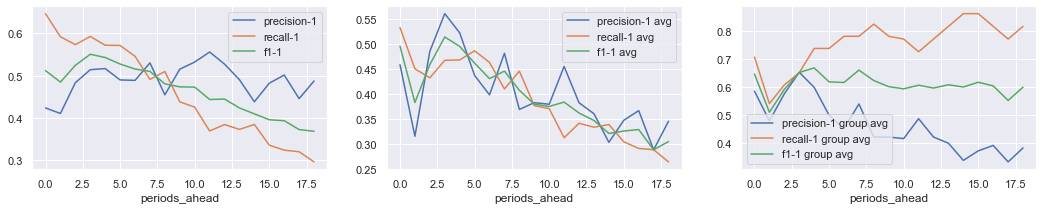

In [18]:
target_id = '1'
sel_thresh = 0.5
periods = [None] + list(range(1, 19, 1))

params = [{'shift': 0, 'periods_ahead': period} for period in periods]
scrs_periods = target_params_evaluation(target_id, params, pipe, sel_thresh=0.5).set_index('periods_ahead')
scrs_periods.index = scrs_periods.index.fillna(0.)

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
for i, col_type in enumerate(['', ' avg', ' group avg']):
    scrs_periods[scr_cols + col_type].plot(ax=ax[i])
plt.show()